# Detecting duplicate questions

### Info 
Date 1st of May 2017

Version 1 

Gilles Daquin

#### Difficulties: 

size of files 

spelling mistakes

no treatment of sematics 

some unicode characters not recognized by system 

laptop not setup for this type development

#### Main difficulties: 

a) extracting features to input in a Machine Learning algorithm

b) a lot of pre-processing on the data is necessary

# Synopsis

### Preparation
a) loading data

b) cleaning up the data

c) creation of dictionary

d) tokenization of questions

e) vectorization of questions

f) Theme description per question

g) Rework training set to fit distribution of test set

### Feature creation (base)
a) Shared word percentage: SharedWord

b) Number of character:    NumberCharaters

c) Cosine similarity:      CosineSim

d) Proximity of Themes:    ThemesProx

e) other?...

### Feature extension
a) X*X

b) X*Y

c) Log X

d) Sqrt(X)

### Feature validation
a) Assessment of feature strength with Random forest algorithm

### Training of model & test
a) train model (could be anything at this stage)

b) Test

### Prepare submission
a) save submission data


# Preparation

In [1]:
%matplotlib inline

#imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re

import sklearn as sk
import nltk
from nltk import word_tokenize, ngrams
from nltk.corpus import stopwords
import gensim

from nltk import bigrams
from nltk import trigrams


In [2]:
verbose = False
#prepare the stop words
STOP_WORDS = nltk.corpus.stopwords.words()

In [3]:
#download the datasets
df_train = pd.read_csv("../Data/train.csv")
df_test = pd.read_csv("../Data/test.csv")

if (verbose):
    print(df_train.shape)
    print(df_test.shape)

### Reduce size of training set for development

Data set is more than 400K long, let's reduce it to speed up development time and testing of code


In [4]:
df_train_clean= df_train.sample(frac=0.1).reset_index(drop=True)
if (verbose):
     df_train_clean["is_duplicate"].sum()

In [5]:
if (verbose):
    df_train_clean.head()

In [6]:
#check for NANs
if (verbose):
    df_train_clean.isnull().sum()

In [7]:
# we need to clean these NaNs
df_train_clean = df_train_clean.dropna()

In [8]:
#verbose = False

In [9]:
if (verbose):
    print df_train_clean.isnull().sum()
    print df_train_clean.shape

### Before processing count number of words to try and differentiate the classes


In [10]:
def compute_length(sentence):
    "remove chars that are not letters or numbers, downcase"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', sentence).lower()
    length = len(sentence.split(" "))
    
    return length



In [11]:
df_train_clean["lengthQ1"]= df_train_clean["question1"].apply(compute_length)
df_train_clean["lengthQ2"]= df_train_clean["question2"].apply(compute_length)


### Stop words removal

In [12]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

In [13]:
if (verbose):
    df_train_clean["question1"][1:10]
    df_train_clean["question2"][1:10] 

In [14]:
df_train_clean["question1"] = df_train_clean["question1"].apply(clean_sentence)
df_train_clean["question2"] = df_train_clean["question2"].apply(clean_sentence)

In [15]:
if (verbose):
    df_train_clean["question1"][10:20]

## Look for common words

In [16]:
def commom_words(sentence1, sentence2):
    
    commonwords = [None] * len(sentence1)
    
    for i in range(len(sentence1)):
        sameWords = set.intersection(set(sentence1[i].split(" ")), set(sentence2[i].split(" ")))
        numberOfWords = len(sameWords)

        commonwords[i] = sameWords
    
    return commonwords

In [17]:
#df_train_clean.reset_index(drop=True)
#df_train_clean = df_train_clean.reindex(index=range(1, len(df_train_clean)), fill_value=0)
#df_train_clean.loc[374] = pd.Series({'id':0, 'qid1':0, 'qid2':0, 'question1':" ",'question2':" ",'is_duplicate':0
#                                    , 'lengthQ1':0,'lengthQ2':0 , 'Common':0})


In [18]:
len(df_train_clean)

40429

In [19]:
#check the words that in common
df_train_clean["Common"]= commom_words(df_train_clean["question1"],df_train_clean["question2"])

In [20]:
#compute the number of common words
df_train_clean["CommonLength"] = df_train_clean["Common"].apply(lambda x: len(x))

In [21]:
#compute the average length of share words
def average_shared_length(length1, length2, shared):
    
    share_length = [None] * len(length1)
    
    for i in range(len(length1)):
        # print shared[i+1]
        if (float(length1[i]+length2[i])>0):
            share_length[i] = float(shared[i])/float(length1[i]+length2[i])
        else:
            share_length[i] = 0

    return share_length

In [22]:
df_train_clean["Shared"]= average_shared_length(df_train_clean["lengthQ1"],df_train_clean["lengthQ2"],
                                                df_train_clean["CommonLength"])

In [23]:
df_train_clean.head()

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,Common,CommonLength,Shared
0,143138,226851,226852,crush girl lives far away long relative,tell girl actually cares thinks lives far away,0,23,19,"{far, away, lives, girl}",4,0.095238
1,236967,348022,348023,australia 100 million people powerful would ec...,abs go away eat carbs,0,15,10,{},0,0.000000
2,140246,222901,222902,fundamental form truth,fundamental truth know,0,8,8,"{fundamental, truth}",2,0.125000
3,31808,58616,58617,one better game development python javascript,game development pygame one better good future,0,11,15,"{development, better, game, one}",4,0.153846
4,292805,414466,414467,could female orgasm,get female orgasm,0,6,8,"{orgasm, female}",2,0.142857


## Lemmatization

(recheck position in preparation)

In [24]:
#let's do some stemming
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

df_train_clean["question1"] = df_train_clean["question1"].apply(lmtzr.lemmatize)
df_train_clean["question2"] = df_train_clean["question2"].apply(lmtzr.lemmatize)

## Stemming

In [25]:
from nltk.stem.porter import PorterStemmer

def stem_tokens(tokens):
 
    porter_stemmer = PorterStemmer()
    print tokens
    wordList = re.sub("[^\w]", " ",  tokens).split()
    stemmed = []
    for item in wordList:
        #print item
        stemmed.append(porter_stemmer.stem(item))
    return stemmed

execute = 0
#a bit too long
if (execute==1):
    df_train_clean["question1"] = df_train_clean["question1"].apply(stem_tokens)
    df_train_clean["question2"] = df_train_clean["question2"].apply(stem_tokens)

In [26]:
#explore possibility to fit training sampling to same proportion of duplicate as in test data back engineering tip)
Resampling = 0
if ( Resampling == 1):
    train_X_dup = train_X[train_y==1]
    train_X_non_dup = train_X[train_y==0]

    train_X = np.vstack([train_X_non_dup, train_X_dup, train_X_non_dup, train_X_non_dup])
    train_y = np.array([0]*train_X_non_dup.shape[0] + [1]*train_X_dup.shape[0] + [0]*train_X_non_dup.shape[0] + [0]*train_X_non_dup.shape[0])
    del train_X_dup
    del train_X_non_dup
    print("Mean target rate : ",train_y.mean())

## Compute lengths post-process

In [27]:
df_train_clean["lengthPP_Q1"]= df_train_clean["question1"].apply(compute_length)
df_train_clean["lengthPP_Q2"]= df_train_clean["question2"].apply(compute_length)

In [28]:
df_train_clean["SharedPP"]= average_shared_length(df_train_clean["lengthPP_Q1"],df_train_clean["lengthPP_Q2"],
                                                df_train_clean["CommonLength"])

In [29]:
#sanity check
df_train_clean.head()

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,Common,CommonLength,Shared,lengthPP_Q1,lengthPP_Q2,SharedPP
0,143138,226851,226852,crush girl lives far away long relative,tell girl actually cares thinks lives far away,0,23,19,"{far, away, lives, girl}",4,0.095238,7,8,0.266667
1,236967,348022,348023,australia 100 million people powerful would ec...,abs go away eat carbs,0,15,10,{},0,0.000000,9,5,0.000000
2,140246,222901,222902,fundamental form truth,fundamental truth know,0,8,8,"{fundamental, truth}",2,0.125000,3,3,0.333333
3,31808,58616,58617,one better game development python javascript,game development pygame one better good future,0,11,15,"{development, better, game, one}",4,0.153846,7,7,0.285714
4,292805,414466,414467,could female orgasm,get female orgasm,0,6,8,"{orgasm, female}",2,0.142857,3,3,0.333333


## Build a word 2 vec Model

In [30]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(df_train_clean)        


In [31]:
from gensim.models import Word2Vec
min_count = 2
size = 100
window = 4
 
model = Word2Vec(corpus, min_count=min_count, size=size, window=window)


In [32]:
model.similarity("guy","girl")

0.98291404218320622

##### Keep note : model may be over fitting as we used to have a lower similarity while using the full corpus

### compute cosine similarity between two questions

for each questions, we will compute the vector for each word then we will sum all the vectors and will take the average value as the length of each questions maye be different and will compare the results of one question against the other to determine the cosine similarity

In [33]:
def avg_feature_vector(words, model, num_features, index2word_set):
        #function to average all words vectors in a given paragraph
        featureVec = np.zeros((num_features,), dtype="float32")
        nwords = 0
        #print words
        #wordList = re.sub("[^\w]", " ",  words[1]).split()
        wordList = words.split()
        #list containing names of words in the vocabulary
        for word in wordList:
            if word in index2word_set:
                nwords = nwords+1
                featureVec = np.add(featureVec, model[word])
                
        if(nwords>0):
            featureVec = np.divide(featureVec, nwords)
        return featureVec

In [38]:
from scipy import spatial

def computeCosine(df1,df2):
    cosineSimilarity = [None] * len(df1)
    
    for i in range(len(df1)):
        sentence_1_avg_vector = avg_feature_vector(df1[i], model, size, model.wv.index2word)
        sentence_2_avg_vector = avg_feature_vector(df2[i], model, size, model.wv.index2word)
        cosineSimilarity[i] =  1 - spatial.distance.cosine(sentence_1_avg_vector,sentence_2_avg_vector)
 
    return cosineSimilarity

In [39]:
#useful to re-initialize while developping
df_train_clean["cosine"] = 0

In [40]:
df_train_clean.head()

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,Common,CommonLength,Shared,lengthPP_Q1,lengthPP_Q2,SharedPP,cosine
0,143138,226851,226852,crush girl lives far away long relative,tell girl actually cares thinks lives far away,0,23,19,"{far, away, lives, girl}",4,0.095238,7,8,0.266667,0
1,236967,348022,348023,australia 100 million people powerful would ec...,abs go away eat carbs,0,15,10,{},0,0.000000,9,5,0.000000,0
2,140246,222901,222902,fundamental form truth,fundamental truth know,0,8,8,"{fundamental, truth}",2,0.125000,3,3,0.333333,0
3,31808,58616,58617,one better game development python javascript,game development pygame one better good future,0,11,15,"{development, better, game, one}",4,0.153846,7,7,0.285714,0
4,292805,414466,414467,could female orgasm,get female orgasm,0,6,8,"{orgasm, female}",2,0.142857,3,3,0.333333,0


In [41]:
#for i in range(len(df_train_clean)):
df_train_clean["cosine"] = computeCosine(df_train_clean["question1"],df_train_clean["question2"])

In [43]:
df_train_clean[df_train_clean["cosine"].isnull()].head()

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,Common,CommonLength,Shared,lengthPP_Q1,lengthPP_Q2,SharedPP,cosine
412,322863,448745,448746,scabs paws,scab,0,9,10,{scabs},1,0.052632,2,1,0.333333,NaN
623,73266,125739,125740,spelling right ninety ninty nineteen ninteen,vicepresident spelled,0,10,4,{},0,0.000000,6,2,0.000000,NaN
657,271009,389008,389009,ebizz,ebizcom,0,3,3,{},0,0.000000,1,1,0.000000,NaN
887,270849,388811,388812,thrill,thrilling mean,0,3,6,{},0,0.000000,1,2,0.000000,NaN
1022,248024,585,244694,bestmytestcom,paypalcornercom,0,3,3,{},0,0.000000,1,1,0.000000,NaN


In [44]:
df_train_clean["cosine"].fillna(0, inplace=True)

In [45]:
df_train_clean.head()

,id,qid1,qid2,question1,question2,is_duplicate,lengthQ1,lengthQ2,Common,CommonLength,Shared,lengthPP_Q1,lengthPP_Q2,SharedPP,cosine
0,143138,226851,226852,crush girl lives far away long relative,tell girl actually cares thinks lives far away,0,23,19,"{far, away, lives, girl}",4,0.095238,7,8,0.266667,0.985668
1,236967,348022,348023,australia 100 million people powerful would ec...,abs go away eat carbs,0,15,10,{},0,0.000000,9,5,0.000000,0.928768
2,140246,222901,222902,fundamental form truth,fundamental truth know,0,8,8,"{fundamental, truth}",2,0.125000,3,3,0.333333,0.857830
3,31808,58616,58617,one better game development python javascript,game development pygame one better good future,0,11,15,"{development, better, game, one}",4,0.153846,7,7,0.285714,0.980470
4,292805,414466,414467,could female orgasm,get female orgasm,0,6,8,"{orgasm, female}",2,0.142857,3,3,0.333333,0.818138


### check with pre-trained corpus as well
time allowing, it may be interesting to use a pre-trained corpus on a much larger data set

In [46]:
# Load Google's pre-trained Word2Vec model.
#model2 = gensim.models.Word2Vec.load_word2vec_format('./model/GoogleNews-vectors-negative300.bin', binary=True)  

### check use of TF-IDF

time allowing probably with not have too much used due too much sparsity

In [47]:
#tfidf = models.TfidfModel(corpus)

### explore possibility to re-sample 

various duplicate density in training vs test may impact outcome positively - time allowing

# Apply Model

### Scale the data

In [48]:
df_train_clean.columns

Index([u'id', u'qid1', u'qid2', u'question1', u'question2', u'is_duplicate',
       u'lengthQ1', u'lengthQ2', u'Common', u'CommonLength', u'Shared',
       u'lengthPP_Q1', u'lengthPP_Q2', u'SharedPP', u'cosine'],
      dtype='object')

In [116]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


list_of_Numeric_fields= ['lengthQ1', 'lengthQ2',
                         'CommonLength','Shared', 
                         'cosine', 'lengthPP_Q1', 
                         'lengthPP_Q2','SharedPP']



In [117]:
df_train_clean[list_of_Numeric_fields].head()

,lengthQ1,lengthQ2,CommonLength,Shared,cosine,lengthPP_Q1,lengthPP_Q2,SharedPP
0,23,19,4,0.095238,0.985668,7,8,0.266667
1,15,10,0,0.000000,0.928768,9,5,0.000000
2,8,8,2,0.125000,0.857830,3,3,0.333333
3,11,15,4,0.153846,0.980470,7,7,0.285714
4,6,8,2,0.142857,0.818138,3,3,0.333333


In [118]:
df_train_clean["Shared"].max()

0.42857142857142855

In [119]:
df_test = df_train_clean.copy()

In [120]:
df_train_clean[list_of_Numeric_fields].head()

,lengthQ1,lengthQ2,CommonLength,Shared,cosine,lengthPP_Q1,lengthPP_Q2,SharedPP
0,23,19,4,0.095238,0.985668,7,8,0.266667
1,15,10,0,0.000000,0.928768,9,5,0.000000
2,8,8,2,0.125000,0.857830,3,3,0.333333
3,11,15,4,0.153846,0.980470,7,7,0.285714
4,6,8,2,0.142857,0.818138,3,3,0.333333


In [121]:
def scaler(column):
    scaled_x = [0.0] * len(column)
    
    minimum = column.min()
    maximum = column.max()
        
    difference = maximum - minimum
    
    for i in range(len(column)):
        scaled_x[i] = (column[i] - minimum) / float(difference)   
    return scaled_x

In [122]:
for i in list_of_Numeric_fields:
        df_test[i] = scaler(df_test[i])

In [123]:
df_test[list_of_Numeric_fields].head()

,lengthQ1,lengthQ2,CommonLength,Shared,cosine,lengthPP_Q1,lengthPP_Q2,SharedPP
0,0.177419,0.162162,0.235294,0.222222,0.986836,0.117647,0.132075,0.533333
1,0.112903,0.081081,0.000000,0.000000,0.934577,0.156863,0.075472,0.000000
2,0.056452,0.063063,0.117647,0.291667,0.869424,0.039216,0.037736,0.666667
3,0.080645,0.126126,0.235294,0.358974,0.982062,0.117647,0.113208,0.571429
4,0.040323,0.063063,0.117647,0.333333,0.832970,0.039216,0.037736,0.666667


In [124]:
#scale only the numerical features of our dataset
#to retry
#scaler.fit_transform(df_train_clean[list_of_Numeric_fields])

### Prepare the entry data

In [125]:
Y = df_test.is_duplicate

In [170]:
from sklearn.cross_validation import train_test_split

#separate our data between training and test data
X_train, X_test, y_train, y_test = train_test_split(df_test[list_of_Numeric_fields], Y, test_size=0.33)

In [171]:
X_train.head()

,lengthQ1,lengthQ2,CommonLength,Shared,cosine,lengthPP_Q1,lengthPP_Q2,SharedPP
10621,0.032258,0.063063,0.058824,0.179487,0.928243,0.019608,0.056604,0.333333
33413,0.064516,0.072072,0.117647,0.259259,0.957426,0.058824,0.056604,0.500000
31204,0.129032,0.171171,0.000000,0.000000,0.860722,0.176471,0.132075,0.000000
19520,0.056452,0.090090,0.176471,0.368421,0.976788,0.039216,0.094340,0.666667
7128,0.048387,0.036036,0.117647,0.388889,0.948861,0.058824,0.037736,0.571429


### Run the models

In [172]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# (a)select a classifier: here random forest
forest = RandomForestClassifier(n_estimators = 60)

adab = AdaBoostClassifier(n_estimators = 60)


In [173]:
# (b)train the model
forestC = forest.fit(X_train,y_train.values.ravel())
adabC = adab.fit(X_train,y_train.values.ravel())

In [174]:
## Try SVM
from sklearn import svm
svmC = svm.SVC()
svmC.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Get the scores

In [175]:
#score with fixed decision
1-y_test.sum()/float(len(y_test))

0.6268925198620896

In [176]:
svmC.score(X_test,y_test.values.ravel())

0.6681906760605606

In [177]:
#score with random forest
forestC.score(X_test,y_test.values.ravel())

0.69172537850397242

In [178]:
#score with Adaboost
adabC.score(X_test,y_test.values.ravel())

0.70641582971068806

# Use regressors

(kaggle code)

In [179]:
from sklearn.metrics import log_loss

def calculate_logloss(y_true, y_pred):
    loss_cal = log_loss(y_true, y_pred)
    return loss_cal

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [181]:
y_rfr_predicted = rfr.predict(X_test)
y_svr_predicted = svr.predict(X_test)

logloss_rfr = calculate_logloss(y_test, y_rfr_predicted)
logloss_svr = calculate_logloss(y_test, y_svr_predicted)

print ("The calculated log loss value on the test set using RFR is = %f" %logloss_rfr)
print ("The calculated log loss value on the test set using SVR is = %f" %logloss_svr)

The calculated log loss value on the test set using RFR is = 1.119681
The calculated log loss value on the test set using SVR is = 0.660681


## Check what features are important

In [182]:
#pick all the features
features = pd.DataFrame(forest.feature_importances_)


In [183]:
#rank the features by order of importance for classification
#this will be useful 
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [184]:
# Print the feature ranking (comes from trial and error looking at the graph below)
Max_number_of_indices = 8

print("Feature ranking:")

for f in range(Max_number_of_indices):
    print("%d. feature %d (%f) percentage %f" % (f + 1, indices[f], importances[indices[f]] , 
                                                 importances[indices[f]]/importances[indices[0]]))


Feature ranking:
1. feature 4 (0.377935) percentage 1.000000
2. feature 3 (0.175359) percentage 0.463993
3. feature 7 (0.140167) percentage 0.370874
4. feature 1 (0.084288) percentage 0.223022
5. feature 0 (0.084238) percentage 0.222891
6. feature 5 (0.048701) percentage 0.128862
7. feature 6 (0.048177) percentage 0.127475
8. feature 2 (0.041134) percentage 0.108840


In [185]:
#top_indices really means here "most important features selected" - first show all the features
Max_number_of_indices = len(importances)

top_indices = indices[:Max_number_of_indices]


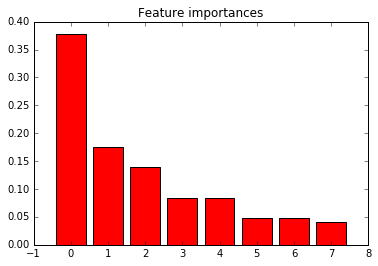

In [186]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(Max_number_of_indices), importances[top_indices], color="r", align="center")
plt.xlim([-1, Max_number_of_indices])
plt.ion()
plt.show()

In [187]:
X_train[top_indices].head()

,cosine,Shared,SharedPP,lengthQ2,lengthQ1,lengthPP_Q1,lengthPP_Q2,CommonLength
10621,0.928243,0.179487,0.333333,0.063063,0.032258,0.019608,0.056604,0.058824
33413,0.957426,0.259259,0.500000,0.072072,0.064516,0.058824,0.056604,0.117647
31204,0.860722,0.000000,0.000000,0.171171,0.129032,0.176471,0.132075,0.000000
19520,0.976788,0.368421,0.666667,0.090090,0.056452,0.039216,0.094340,0.176471
7128,0.948861,0.388889,0.571429,0.036036,0.048387,0.058824,0.037736,0.117647


not surprisingly, the cosine similarity is the most significative features in the classification